In [ ]:
pip install opencv-python-headless pytesseract pyzbar

In [ ]:
!apt install libzbar0

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libzbar0 is already the newest version (0.23.92-4build2).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


Barcode Detection and Comparison Result:
Found CODE128 barcode: 4122283
Match found in predefined data! This id is belongs to our college 


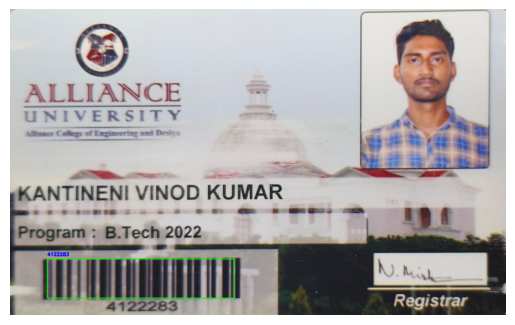

In [ ]:
import cv2
import pytesseract
from pyzbar import pyzbar
import matplotlib.pyplot as plt

# Function to read predefined barcodes from data.txt
def load_predefined_barcodes(file_path):
    with open(file_path, 'r') as file:
        predefined_barcodes = file.read().splitlines()
    return predefined_barcodes

# Function to extract and compare barcode from the image
def extract_and_compare_barcode(image_path, predefined_barcodes):
    # Load the image
    image = cv2.imread(image_path)

    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect barcodes in the image
    barcodes = pyzbar.decode(gray)

    # Initialize a flag to track if any barcode matched
    found_match = False

    # Loop through detected barcodes and decode
    for barcode in barcodes:
        # Extract the barcode bounding box location
        (x, y, w, h) = barcode.rect
        # Draw a rectangle around the barcode in the image
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Decode the barcode data
        barcode_data = barcode.data.decode("utf-8")
        barcode_type = barcode.type

        # Display the barcode type and data
        print(f"Found {barcode_type} barcode: {barcode_data}")

        # Check if the detected barcode matches any in the predefined list
        if barcode_data in predefined_barcodes:
            print("Match found in predefined data! This id is belongs to our college ")
            found_match = True  # Set flag to true if a match is found
        else:
            print("No match found in predefined data.This id is not belongs to our college")

        # Put the barcode text below the barcode
        cv2.putText(image, f"{barcode_data}", (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Check if no barcodes matched at all
    if not found_match:
        print("Barcode data not found in predefined data.This id is not belongs to our college")

    # Display the image with annotations
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

# Path to the image file and predefined data file
image_path = '/content/4122283.jpg'
data_file_path = '/content/data.txt'

# Load predefined barcodes from file
predefined_barcodes = load_predefined_barcodes(data_file_path)

# Extract and compare barcode
print("Barcode Detection and Comparison Result:")
extract_and_compare_barcode(image_path, predefined_barcodes)

In [ ]:
pip install tensorflow tensorflow_hub matplotlib tf-explain

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Shape of attributions: (224,)


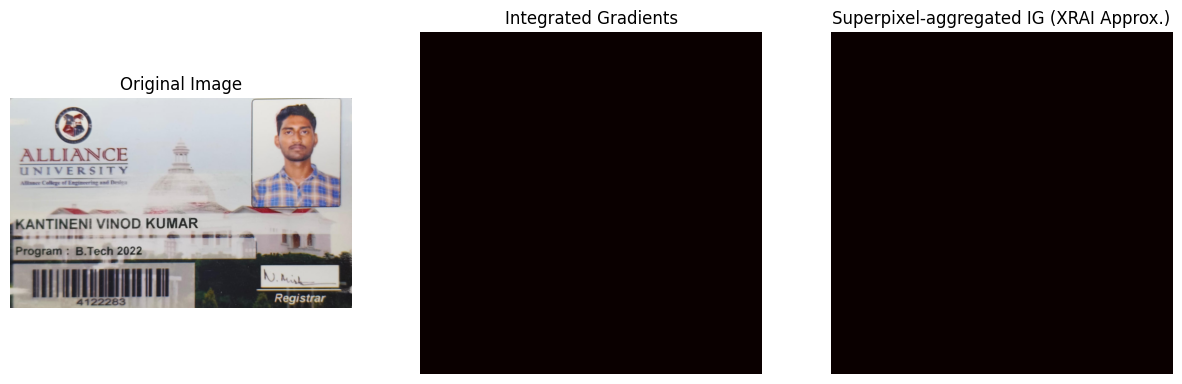

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.segmentation import slic
from tf_explain.core.integrated_gradients import IntegratedGradients

# Load a TensorFlow/Keras model (using MobileNetV2 as a placeholder)
model = tf.keras.applications.MobileNetV2(weights="imagenet", include_top=True)

# Preprocessing function for the model input
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    image = cv2.resize(image, (224, 224))  # Resize to model input size
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image

# Function to generate superpixels
def generate_superpixels(image, num_segments=50):
    segments = slic(image, n_segments=num_segments, compactness=10, sigma=1)
    return segments

# Load and preprocess the image
image_path = '/content/4122283.jpg'
image = preprocess_image(image_path)
image = np.expand_dims(image, axis=0)  # Add batch dimension

# Target class for explanation (choose based on model's output)
target_class = np.argmax(model.predict(image))

# Generate superpixels on the original image (without batch dimension)
superpixels = generate_superpixels(image[0])

# Apply Integrated Gradients
integrated_gradients = IntegratedGradients()
ig_explanation = integrated_gradients.explain(
    validation_data=(image, None),
    model=model,
    class_index=target_class,
)

# Check and print the shape of attributions
attributions = ig_explanation[0]
print("Shape of attributions:", attributions.shape)

# Ensure attributions match the input image size
if attributions.ndim == 1 or attributions.size != 224 * 224:
    # Reshape to the correct shape for the image if necessary
    attributions = np.resize(attributions, (224, 224))

# Initialize aggregated attribution map
aggregated_attributions = np.zeros_like(attributions)

# Aggregate IG explanations over superpixels
for segment in np.unique(superpixels):
    mask = superpixels == segment
    aggregated_attributions[mask] = attributions[mask].mean()  # Average IG values within each superpixel

# Plot results
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(cv2.imread(image_path)[..., ::-1])  # Original image in RGB
plt.axis('off')
plt.title("Original Image")

# Integrated Gradients Explanation
plt.subplot(1, 3, 2)
plt.imshow(attributions, cmap='hot')
plt.axis('off')
plt.title("Integrated Gradients")

# Superpixel Aggregated Explanation (XRAI approximation)
plt.subplot(1, 3, 3)
plt.imshow(aggregated_attributions, cmap='hot')
plt.axis('off')
plt.title("Superpixel-aggregated IG (XRAI Approx.)")

plt.show()


In [ ]:
!pip install captum

In [ ]:
pip install lime

In [ ]:
import numpy as np
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Updated function to return match status for LIME, ensuring 2D output
def barcode_match_predict(image_array, predefined_barcodes):
    results = []
    for image in image_array:
        # Convert image from RGB to BGR for OpenCV compatibility
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Convert image to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Detect barcodes in the image
        barcodes = pyzbar.decode(gray)

        # Check if any barcode in this perturbed image matches the predefined barcodes
        match_found = any(barcode.data.decode("utf-8") in predefined_barcodes for barcode in barcodes)

        # Append 1 if a match is found, else 0, ensuring it's in a list for 2D shape
        results.append([1 if match_found else 0])  # Changed to list of lists

    return np.array(results)  # Now a 2D numpy array

  0%|          | 0/10 [00:00<?, ?it/s]

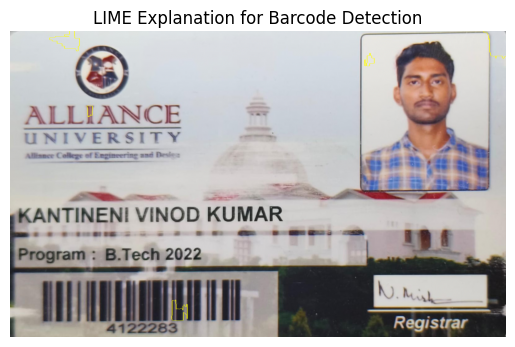

In [ ]:
# Initialize the LIME explainer
lime_explainer = lime_image.LimeImageExplainer()

# Load a sample image
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for LIME

# Use LIME to explain the prediction on this image
explanation = lime_explainer.explain_instance(
    image_rgb,
    classifier_fn=lambda x: barcode_match_predict(x, predefined_barcodes),  # Use modified prediction function
    top_labels=1,
    hide_color=0,
    num_samples=10
)

# Display the explanation
temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=False
)
# Show the LIME explanation
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.axis("off")
plt.title("LIME Explanation for Barcode Detection")
plt.show()



In [ ]:
pip install shape

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.23s/it]               


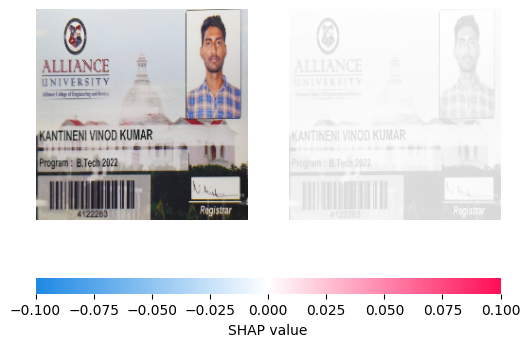

In [ ]:
import numpy as np
import shap
from pyzbar import pyzbar
import cv2
import matplotlib.pyplot as plt

# Barcode detection function for SHAP compatibility
def barcode_match_predict(image_array, predefined_barcodes):
    results = []
    for image in image_array:
        # Convert image to BGR format for OpenCV compatibility
        image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Convert image to grayscale for barcode processing
        gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)

        # Detect barcodes in the image
        barcodes = pyzbar.decode(gray)

        # Check if any barcode matches the predefined list
        match_found = any(barcode.data.decode("utf-8") in predefined_barcodes for barcode in barcodes)

        # Append 1 if a match is found, else 0
        results.append(1 if match_found else 0)
    return np.array(results)

# Sample image setup
image_path = "/content/4122283.jpg"
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(cv2.resize(image, (224, 224)), cv2.COLOR_BGR2RGB)  # Resize and convert to RGB
sample_image = np.expand_dims(image_rgb, axis=0)  # Add batch dimension

# Load predefined barcodes from file or define directly
predefined_barcodes = ["1234567890", "0987654321"]  # Example barcodes

# Initialize SHAP's Image masker and explainer
masker = shap.maskers.Image("inpaint_telea", sample_image[0].shape)  # `inpaint_telea` is a common method for masking in images
explainer = shap.Explainer(
    lambda x: barcode_match_predict(x, predefined_barcodes),
    masker=masker,
    algorithm="partition"
)

# Get SHAP values for the sample image
shap_values = explainer(sample_image)

# Display the SHAP explanation
shap.image_plot(shap_values, sample_image)
